### About this Project:

This Project aims to analyze News Articles using NLP techniques, to qunatify about how a particular news is potrayed by differet media houses.
Ultimatly aiming to understand if there are any biases.

#### What is Bias?
- Inclination or prejudice for or against one person or group, especially in a way considered to be unfair.

#### Challenges:
Its is hard to define what is considered as bias quantitatively as there are multiple qualitative factors involved.

#### Project Flow
- Extract Meta Data from Google News Search results
- Using the URLs in the Meta Data extract News Article Text and other related information using News3k package.
- Preprocess the text information and other features.
- Use pretrained Models to understand the Over all sentiment of the Article and how Sentiment Changes from start to end of the article.
- Use pretrained Models to understand the Over all emotion of the Article and how emotion Changes from start to end of the article.
- Extract Other textual features.
- Do Clustering of the articles.
- Identify the what features contribute to the Cluster formations.
- Future Work



### Importing Required Packages

In [2]:
# Data Processing
import pandas as pd
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
import datetime
import numpy as np
import re
import ast
import time
import string
import neattext as nt
from textblob import TextBlob
import re
from collections import Counter

#Data Extraction
# from GoogleNews import GoogleNews
# from newspaper import Article
# from newspaper import Config

#Analysis
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

#Visulization
import plotly.express as px
import matplotlib.pyplot as plt
from wordcloud import WordCloud

#Models
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoModelWithLMHead

#Others
from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\balaji\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\balaji\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\balaji\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### Extract Dataset

#### Configuration

In [ ]:
#config will allow us to access the specified url for which we are #not authorized. Sometimes we may get 403 client error while parsing #the link to download the article.
user_agent = 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.102 Safari/537.36'
# config = Config()
# config.browser_user_agent = user_agent
# config.request_timeout = 15

#Search Configurations
region = 'IN'
start_date =  datetime.date(2023, 1, 24)  #MM/DD/YYYY #datetime.date(2022, 1, 25)'01/24/2023'
end_date =  datetime.date(2023, 3, 31)
no_of_days_from_start_date = end_date - start_date
no_of_days_from_start_date = no_of_days_from_start_date.days
interval_days = 3
periods = round(no_of_days_from_start_date/interval_days)

search_string = 'Adani'
lang='en'
region='IN'
no_of_pages = 3
sleep_time = 20.0

#### Extract Meta Data

In [ ]:
# Contains the final results = news filtered by the criteria 
# (news that in their description contains the search term).
final_results = []
# Initial list of results - it will contain a list of dictionaries (dict).
results = []
for period in tqdm(range(1,periods+1)):
        #Creating Dynamic Date Ranges
        if period == 1:
            dynamic_end_date = start_date+datetime.timedelta(days=interval_days)
            dynamic_start_date = start_date
        else:
            dynamic_start_date = dynamic_end_date+datetime.timedelta(days=1)
            dynamic_end_date = dynamic_start_date+datetime.timedelta(days=interval_days)
        print(f'Getting News for the period {dynamic_start_date} to {dynamic_end_date}')
        googlenews=GoogleNews(start=str(dynamic_start_date.strftime("%m/%d/%Y")),end=str(dynamic_end_date.strftime("%m/%d/%Y")),lang=lang, region=region) # I suppose the date is in "MM/dd/yyyy" format...
        googlenews.search(search_string)
        
    # Get first x pages with the results and append those results to the list - you can set any other range according to  your needs: 
        for page in range(1,no_of_pages+1):
            print(f'Getting News for the period {dynamic_start_date} to {dynamic_end_date}, Page NO : {page}')
            print('Waiting..')
            time.sleep(sleep_time) # Sleep time is set in order not to be blocked for continous searching, please reduce this to extract the data faster
            googlenews.getpage(page) # Consider add an timer for avoid multiple calls and get "HTTP Error 429: Too Many Requests" error.
            results.extend(googlenews.result(sort=True))

In [ ]:
# Remove duplicates and include to the "final_results" list 
for item in results: 
            #if (item not in final_results and (search_string in item["desc"])): # only the news that includes in their description the search term:
                final_results.append(item)
# Build and show the final dataframe: 
df=pd.DataFrame(final_results).drop_duplicates()
df.to_csv(f'./data/raw_data/Meta_data_{search_string}.csv',index=False)

#### Manual URLs

In [ ]:
df_manual_meta = pd.read_csv(f'./data/raw_data/Manual_Adani Articles.csv')

In [ ]:
#Combining both Extracted Meta URLs & Manual URLs
df = pd.read_csv(f'./data/raw_data/Meta_data_{search_string}.csv')
df = pd.concat([df,df_manual_meta])
df = df.drop_duplicates()

#### Extract Full Article from Meta Data's URLs

In [ ]:
# Filter for only certain Media Houses
filter_list = [ 'ABP LIVE','Adani Watch','Ahmedabad Mirror','Bar and Bench','Business Today','CNBCTV18.com',
 'Daily Pioneer','Financial Times','Hindustan Times','IFR','India Today','Indian National Congress',
 'Indtoday','Live Law','Mint','NDTV.com','Onmanorama','OpIndia','Outlook India','PTI','Rediff.com',
 'Republic','Scroll','SwarajyaMag','Telangana Today','Telegraph India','The Business Times','The Economic Times',
 'The Hindu','The Hindu Business Line','The Indian Express','The Morning Context','The New Indian Express',
 'The Wire','ThePrint','Times Now','Times of India','Tribune India','Wire','Zee Business']

In [ ]:
df = df[df['media'].isin(filter_list)].drop_duplicates()

In [ ]:
list = []
failed_list = []
for ind in tqdm(df.index):
    dict={}
    url = (df[df.index ==ind]['link']).to_list()[0]
    article = Article(url)
    try:
        article.download()
        article.parse()
        article.nlp()
        dict['Meta_Publisher'] = (df[df.index ==ind]['media']).to_list()[0]
        dict['Meta_datetime'] = (df[df.index ==ind]['datetime']).to_list()[0]
        dict['Meta_title'] = (df[df.index ==ind]['title']).to_list()[0]
        dict['Meta_link'] = (df[df.index ==ind]['link']).to_list()[0]
        dict['Meta_desc'] = (df[df.index ==ind]['desc']).to_list()[0]
        try:
            dict['Published_Date']=str(article.publish_date)
        except:
            dict['Published_Date']=str(article.publish_date)
        try:
            dict['Title']=article.title
        except:
            dict['Title']='NA'
        try:
            dict['Article']=article.text
        except:
            dict['Article']='NA'
        try:
            dict['Summary']=article.summary
        except:
            dict['Summary']='NA'
        try:
            dict['Authors'] = article.authors
        except:
            dict['Authors'] = 'NA'
        try:
            dict['Keywords'] = article.keywords
        except:
            dict['Keywords'] = 'NA'   
        list.append(dict)
    except:
        failed_list.append(ind)
        dict['Meta_Publisher'] = (df[df.index ==ind]['media']).to_list()[0]
        dict['Meta_datetime'] = (df[df.index ==ind]['datetime']).to_list()[0]
        dict['Meta_title'] = (df[df.index ==ind]['title']).to_list()[0]
        dict['Meta_link'] = (df[df.index ==ind]['link']).to_list()[0]
        dict['Meta_desc'] = (df[df.index ==ind]['desc']).to_list()[0]
        dict['Published_Date']=str(article.publish_date)
        dict['Title']='NA'
        dict['Article']='NA'
        dict['Summary']='NA'
        dict['Authors'] = 'NA'
        dict['Keywords'] = 'NA'
        list.append(dict)

In [ ]:
news_df=pd.DataFrame(list)
news_df.to_csv('./data/processed_data/extracted_data_new.csv',index=False)
print('Number Failed Articles : ',len(failed_list)/len(df.index),'%')

### Data Pre - Processing

In [ ]:
df_raw = pd.read_csv('./data/processed_data/extracted_data_new.csv')

In [ ]:
pd.DataFrame(df_raw['Meta_Publisher'].value_counts())

In [ ]:
fillna_cols = ['Title','Article','Summary','Authors','Keywords']
df_raw[fillna_cols] = df_raw[fillna_cols].fillna('NA') #Filling NA for the cols where we have null values
#Removing rows where we do not have Article text
df_raw = df_raw[df_raw['Article'] != 'NA']
df_raw.reset_index(drop = True,inplace=True)
df_raw['index'] = df_raw.index # Creating an index column
df_raw['Authors_Count'] = df_raw.Authors.transform(ast.literal_eval).str.len() # Getting number of Authors, if there are no Authors info then it would be set to 0.

In [ ]:
print('Missing Data on Authors: ',df_raw[df_raw['Authors_Count']== 0].shape[0]/df_raw.shape[0])

In [ ]:
authors_list = []
#Removing the list format
for authors in df_raw['Authors']:
    temp = authors[1:-1].replace("'", "")
    if temp == '':
        authors_list.append('Not Available')    
    else:
        authors_list.append(temp)
df_raw.Authors = authors_list

Remove noise
- stopwords
- special characters
- punctuations
- hashtags
- @userhandles
- extra spaces
- emails
- special chars
- & many more


In [ ]:
#Text Cleaning
failed_indexs = []
for col in ['Meta_title','Meta_desc','Title','Article','Summary']:
    for ind in df_raw.index :
        try:
            sentx = nt.TextFrame(text=df_raw[col][ind])
            text = sentx.remove_hashtags()
            text = text.remove_userhandles()
            text = text.remove_bad_quotes()
            text = text.remove_emails()
            text = text.remove_currency_symbols()
            text = text.remove_dates()
            text = text.remove_phone_numbers()
            text = text.remove_multiple_spaces()
            text = text.remove_html_tags()
            text = text.remove_emojis()
            text = text.remove_emails()
            #text = text.remove_puncts()
            text = text.remove_urls()
            text = text.remove_special_characters()
            #text = text.remove_stopwords()
            text = str(text)
            text = text.replace("\n", "")
            text = text.replace("’s", "")
            df_raw[col][ind] = text
        except:
            failed_indexs.append(ind)
            pass
    print(f'Cleaning Completed for : {col}')
print('Failed Cases : ',len(failed_indexs))

In [ ]:
#Grouping similar media houses to same entity
df_raw.loc[df_raw['Meta_Publisher'].isin(['Wire',]),'Meta_Publisher'] = 'The Wire'

In [ ]:
df_raw.to_csv('./data/processed_data/processed_data.csv',index=False)

### Using Pre-Trained Models for Sentiment & Emotion Classification

#### Sentiment Prediction - Article

In [ ]:
df_raw = pd.read_csv('./data/processed_data/processed_data.csv')

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis")
model = AutoModelForSequenceClassification.from_pretrained("mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis")

In [ ]:
#Creating Empty Columns
df_raw['sentiment_flow']  = np.nan
df_raw['sentiment_flow_score'] = np.nan

In [ ]:
def get_sentiment(tokens):
    outputs = model(**tokens)
    probabilities = torch.nn.functional.softmax(outputs[0],dim = -1)

def chunk_text_to_window_size_and_predict_prob(input_ids,attention_mask,total_length,window_length):
    proba_list = []
    start = 0
    window_length = window_length

    loop =True
    while loop:
        end = start + window_length
        if end>= total_length:
            loop = False
            end = total_length
        # Define teh text chunk
        input_id_chunk = input_ids[start:end]
        attention_mask_chunk = attention_mask[start:end]

        # Append [CLS] and [SEP]
        input_id_chunk = [101] + input_id_chunk + [102]
        attention_mask_chunk = [1] + attention_mask_chunk + [1]

        # Convert type list to pytroch tensor
        input_dict = {
            'input_ids' : torch.Tensor([input_id_chunk]).long(),
            'attention_mask' : torch.Tensor([attention_mask_chunk]).int()
        }

        outputs = model(**input_dict)
        probabilities = torch.nn.functional.softmax(outputs[0],dim = -1)
        proba_list.append(probabilities)
        start = end

    return proba_list

def get_mean_from_proba(proba_list,index):
    with torch.no_grad():
        ###
        temp_sentiment = []
        temp_sentiment_score = []
        for list in proba_list:
            with torch.no_grad():
                temp_score = round(list.max().item(),2)
                temp_sentiment_score.append(temp_score)
                temp_senti = torch.argmax(list).item()
                temp_sentiment.append(temp_senti)
            df_raw['sentiment_flow'] [index] = str(temp_sentiment)
            df_raw['sentiment_flow_score'][index] = str(temp_sentiment_score)
        ###
        stacks = torch.stack(proba_list)
        stacks = stacks.resize(stacks.shape[0],stacks.shape[2])
        mean = stacks.mean(dim = 0)
        score = round(mean.max().item(),2)
        mean = torch.argmax(mean).item()
    return mean ,score

In [ ]:
Article_Overall_Sentiment = []
Article_Overall_Sentiment_score = []
for index in tqdm(df_raw['index']):
    tokens = tokenizer.encode_plus( df_raw['Article'][index],add_special_tokens=False)
    input_ids = tokens['input_ids']
    attention_mask = tokens['attention_mask']
    proba_list = chunk_text_to_window_size_and_predict_prob(input_ids,attention_mask,total_length = len(input_ids),window_length = int(len(input_ids)/11))
    article_sentiment,score = get_mean_from_proba(proba_list,index)
    Article_Overall_Sentiment.append(article_sentiment)
    Article_Overall_Sentiment_score.append(score)

In [1]:
df_raw['Article_Overall_Sentiment'] = Article_Overall_Sentiment
df_raw['Article_Overall_Sentiment_score'] = Article_Overall_Sentiment_score
replace_values = {0: "Negative",
                    1: "Neutral",
                    2: "Positive"}
df_raw['Article_Overall_Sentiment'] = df_raw['Article_Overall_Sentiment'].map(replace_values)

NameError: name 'Article_Overall_Sentiment' is not defined

In [ ]:
df_temp = pd.DataFrame(df_raw['sentiment_flow'].str.split().values.tolist(),columns=
             ['Article_sentiment_flow_1',
              'Article_sentiment_flow_2',
              'Article_sentiment_flow_3',
              'Article_sentiment_flow_4',
              'Article_sentiment_flow_5',
              'Article_sentiment_flow_6',
              'Article_sentiment_flow_7',
              'Article_sentiment_flow_8',
              'Article_sentiment_flow_9',
              'Article_sentiment_flow_10',
              'Article_sentiment_flow_11',
              'Article_sentiment_flow_12',
              'Article_sentiment_flow_13',
              'Article_sentiment_flow_14',
              'Article_sentiment_flow_15',
             ])
df_temp.drop(['Article_sentiment_flow_13',
              'Article_sentiment_flow_14',
              'Article_sentiment_flow_15'],axis=1,inplace=True)
#Cleaning the values
for col in df_temp.columns:
    df_temp[col] = df_temp[col].str.replace('[', '')
    df_temp[col] = df_temp[col].str.replace(']', '')
    df_temp[col] = df_temp[col].str.replace(',', '')
df_raw.drop(['sentiment_flow'],axis=1,inplace=True)
df_raw = pd.concat([df_raw,df_temp],axis=1)

In [ ]:
df_temp = pd.DataFrame(df_raw['sentiment_flow_score'].str.split().values.tolist(),columns=
             ['Article_sentiment_flowscore_1',
              'Article_sentiment_flowscore_2',
              'Article_sentiment_flowscore_3',
              'Article_sentiment_flowscore_4',
              'Article_sentiment_flowscore_5',
              'Article_sentiment_flowscore_6',
              'Article_sentiment_flowscore_7',
              'Article_sentiment_flowscore_8',
              'Article_sentiment_flowscore_9',
              'Article_sentiment_flowscore_10',
              'Article_sentiment_flowscore_11',
              'Article_sentiment_flowscore_12',
              'Article_sentiment_flowscore_13',
              'Article_sentiment_flowscore_14',
              'Article_sentiment_flowscore_15',
             ])
df_temp.drop(['Article_sentiment_flowscore_13',
              'Article_sentiment_flowscore_14',
              'Article_sentiment_flowscore_15'],axis=1,inplace=True)
#Cleaning the values
for col in df_temp.columns:
    df_temp[col] = df_temp[col].str.replace('[', '')
    df_temp[col] = df_temp[col].str.replace(']', '')
    df_temp[col] = df_temp[col].str.replace(',', '')
df_raw.drop(['sentiment_flow_score'],axis=1,inplace=True)
df_raw = pd.concat([df_raw,df_temp],axis=1)

In [ ]:
replace_values = {'0': "Negative",
                    '1': "Neutral",
                    '2': "Positive"}
replace_cols = ['Article_sentiment_flow_1',
       'Article_sentiment_flow_2', 'Article_sentiment_flow_3',
       'Article_sentiment_flow_4', 'Article_sentiment_flow_5',
       'Article_sentiment_flow_6', 'Article_sentiment_flow_7',
       'Article_sentiment_flow_8', 'Article_sentiment_flow_9',
       'Article_sentiment_flow_10', 'Article_sentiment_flow_11',
       'Article_sentiment_flow_12']
for col in replace_cols:
    df_raw[col] = df_raw[col].map(replace_values)

#### Sentiment Prediction - Title

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis")
model = AutoModelForSequenceClassification.from_pretrained("mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis")

In [ ]:
#Creating Empty Columns
df_raw['sentiment_flow']  = np.nan
df_raw['sentiment_flow_score'] = np.nan

#### Sentiment Prediction - Summary

In [ ]:
Title_Overall_Sentiment = []
Tile_Overall_Sentiment_score = []
for index in tqdm(df_raw['index']):
    tokens = tokenizer.encode_plus( df_raw['Title'][index],add_special_tokens=False)
    input_ids = tokens['input_ids']
    attention_mask = tokens['attention_mask']
    proba_list = chunk_text_to_window_size_and_predict_prob(input_ids,attention_mask,total_length = len(input_ids),window_length = int(len(input_ids)/1))
    Title_sentiment,score = get_mean_from_proba(proba_list,index)
    Title_Overall_Sentiment.append(Title_sentiment)
    Tile_Overall_Sentiment_score.append(score)

In [ ]:
df_raw['Title_Overall_Sentiment'] = Title_Overall_Sentiment
df_raw['Title_Overall_Sentiment_score'] = Tile_Overall_Sentiment_score
replace_values = {0: "Negative",
                    1: "Neutral",
                    2: "Positive"}
df_raw['Title_Overall_Sentiment'] = df_raw['Title_Overall_Sentiment'].map(replace_values)

In [ ]:
df_raw.drop(['sentiment_flow','sentiment_flow_score'],axis = 1, inplace = True)

In [ ]:
df_raw.to_csv('./data/processed_data/processed_data.csv',index=False)

In [ ]:
#Analysis part - Refer later
# pd.DataFrame(df_raw['Article_Overall_Sentiment'].value_counts())/df_raw['Article_Overall_Sentiment'].count()
# pd.DataFrame(df_raw.groupby('Article_Overall_Sentiment')['Article_Overall_Sentiment_score'].mean())
# df_temp = df_raw.groupby(['Meta_Publisher','Article_Overall_Sentiment']).agg({'Article_Overall_Sentiment':'count'}).rename(columns={'Article_Overall_Sentiment':'count'}).reset_index()
# df_temp1 = df_raw.groupby(['Meta_Publisher']).agg({'Article_Overall_Sentiment':'count'}).rename(columns={'Article_Overall_Sentiment':'Overallcount'}).reset_index()
# df_temp = pd.merge(df_temp,df_temp1, on=['Meta_Publisher'],how = 'inner')
# df_temp['Percentage'] = round(df_temp['count'] / df_temp['Overallcount'] , 2)
# df_temp = df_temp.pivot_table(columns=['Article_Overall_Sentiment'], index= ['Meta_Publisher'], values=['Percentage']).fillna(0.0).reset_index()
# df_temp = df_temp.droplevel(0, axis=1)
# df_temp.columns = ['Media' ,'Negative',	'Neutral',	'Positive']
# mxs = df_temp.eq(df_temp.max(axis=1), axis=0)
# # join the column names of the max values of each row into a single string
# df_temp['Dominant'] = mxs.dot(mxs.columns + ', ').str.rstrip(', ')
# df_raw = df_raw.sort_values(['Meta_datetime','Meta_Publisher'],ascending=True).reset_index(drop=True)
# df_raw.reset_index(drop=True,inplace = True)
# df_raw['index'] = df_raw.index
# df_raw.to_csv('./data/processed_data/processed_data1.csv',index=False)

#### Emotion Prediction

In [ ]:
#Reading Processed data
df_raw = pd.read_csv('./data/processed_data/processed_data.csv')

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("mrm8488/t5-base-finetuned-emotion")
model = AutoModelWithLMHead.from_pretrained("mrm8488/t5-base-finetuned-emotion")

In [ ]:
df_raw['emotion_flow']  = np.nan
df_raw['emotion_flow_score'] = np.nan

In [ ]:
def chunk_text_to_window_size_and_predict_prob(input_ids,total_length,window_length):
    proba_list = []
    start = 0
    input_ids = input_ids[0]
    window_length = window_length
    loop =True
    while loop:
        end = start + window_length
        if end>= total_length:
            loop = False
            end = total_length
        # Define teh text chunk
        input_id_chunk = input_ids[start:end]
        outputs = model.generate(input_ids=input_id_chunk.unsqueeze(0),
               max_length=2)
        dec = [tokenizer.decode(ids) for ids in outputs]
        label = dec[0]
        proba_list.append(label)
        start = end
    return proba_list

In [ ]:
Article_Overall_Emotion = []
Article_Overall_Emotion_flow = []
for index in tqdm(df_raw['index']):
        input_ids = tokenizer.encode(df_raw['Article'][index] + '</s>', return_tensors='pt')
        proba_list = chunk_text_to_window_size_and_predict_prob(input_ids,total_length = len(input_ids[0]),window_length = int(len(input_ids[0])/11))
        #getting max emotion
        overall_emotion = Counter(proba_list)
        overall_emotion = Counter(proba_list)
        overall_emotion = overall_emotion.most_common(1)
        Article_Overall_Emotion.append(overall_emotion)
        Article_Overall_Emotion_flow.append(proba_list)     

In [ ]:
#Cleaning and reassignment of Article_Overall_Emotion_flow
list_of_emotions = ['sadness','joy','love','anger','fear','surprise']
final_emotion_list = []
for list in Article_Overall_Emotion_flow:
    cleaned_emotion = []
    for emotion in list:
        temp_emotion = (emotion[6:])
        if temp_emotion in list_of_emotions:
            cleaned_emotion.append(temp_emotion)
        else:
            cleaned_emotion.append(np.NaN)
    final_emotion_list.append(cleaned_emotion)

In [ ]:
df_raw['Article_Overall_Emotion_flow'] = final_emotion_list
df_temp = pd.DataFrame(df_raw['Article_Overall_Emotion_flow'].to_list(),columns=[
'Article_emotion_flow_1',
'Article_emotion_flow_2',
'Article_emotion_flow_3',
'Article_emotion_flow_4',
'Article_emotion_flow_5',
'Article_emotion_flow_6',
'Article_emotion_flow_7',
'Article_emotion_flow_8',
'Article_emotion_flow_9',
'Article_emotion_flow_10',
'Article_emotion_flow_11',
'Article_emotion_flow_12',
'Article_emotion_flow_13',
'Article_emotion_flow_14',
'Article_emotion_flow_15',
'Article_emotion_flow_16',
'Article_emotion_flow_17',
'Article_emotion_flow_18',
'Article_emotion_flow_19',
'Article_emotion_flow_20',
'Article_emotion_flow_21'
]
)
df_temp.drop(['Article_emotion_flow_13',
'Article_emotion_flow_14',
'Article_emotion_flow_15',
'Article_emotion_flow_16',
'Article_emotion_flow_17',
'Article_emotion_flow_18',
'Article_emotion_flow_19',
'Article_emotion_flow_20',
'Article_emotion_flow_21'],axis=1,inplace=True)
df_raw.drop(['Article_Overall_Emotion_flow'],axis=1,inplace = True)
df_raw = pd.concat([df_raw,df_temp],axis=1)

In [ ]:
#Cleaning and reassignment of Article_Overall_Emotion_flow
list_of_emotions = ['sadness','joy','love','anger','fear','surprise']
final_emotion_list = []
for list in Article_Overall_Emotion:
        temp_emotion = (list[0][0][6:])
        if temp_emotion in list_of_emotions:
            final_emotion_list.append(temp_emotion)
        else:
            final_emotion_list.append(np.NaN)

In [ ]:
df_raw['Article_Overall_Emotion'] = final_emotion_list

In [ ]:
df_raw.drop(['emotion_flow', 'emotion_flow_score'],axis=1,inplace=True)

In [ ]:
df_raw.to_csv('./data/processed_data/processed_data.csv',index=False)

In [ ]:
df_raw = pd.read_csv('./data/processed_data/processed_data.csv')

In [ ]:
# Analysis part -> Refer later
# pd.DataFrame(df_raw['Article_Overall_Emotion'].value_counts())/df_raw['Article_Overall_Emotion'].count()
# df_temp = df_raw.groupby(['Meta_Publisher','Article_Overall_Emotion']).agg({'Article_Overall_Emotion':'count'}).rename(columns={'Article_Overall_Emotion':'count'}).reset_index()
# df_temp1 = df_raw.groupby(['Meta_Publisher']).agg({'Article_Overall_Emotion':'count'}).rename(columns={'Article_Overall_Emotion':'Overallcount'}).reset_index()
# df_temp = pd.merge(df_temp,df_temp1, on=['Meta_Publisher'],how = 'inner')
# df_temp['Percentage'] = round(df_temp['count'] / df_temp['Overallcount'] , 2)
# df_temp = df_temp.pivot_table(columns=['Article_Overall_Emotion'], index= ['Meta_Publisher'], values=['Percentage']).fillna(0.0).reset_index()
# df_temp = df_temp.droplevel(0, axis=1)


In [ ]:
# Polarity, Subjectivity
# Creating Features
df_raw[['Article_polarity', 'Article_subjectivity']] = df_raw['Article'].apply(lambda Text: pd.Series(TextBlob(Text).sentiment))
df_raw[['Title_polarity', 'Tile_subjectivity']] = df_raw['Title'].apply(lambda Text: pd.Series(TextBlob(Text).sentiment))

In [ ]:
df_raw.to_csv('./data/processed_data/processed_data.csv',index=False)

### Clustering

In [3]:
df_raw = pd.read_csv('./data/processed_data/processed_data.csv')

#### Simplified clustering

In [4]:
req_cols = ['Meta_Publisher', 'Authors_Count', 'Article_Overall_Sentiment',
       'Article_Overall_Sentiment_score', 'Article_sentiment_flow_1',
       'Article_sentiment_flow_2', 'Article_sentiment_flow_3',
       'Article_sentiment_flow_4', 'Article_sentiment_flow_5',
       'Article_sentiment_flow_6', 'Article_sentiment_flow_7',
       'Article_sentiment_flow_8', 'Article_sentiment_flow_9',
       'Article_sentiment_flow_10', 'Article_sentiment_flow_11',
       'Article_sentiment_flow_12', 'Article_sentiment_flowscore_1',
       'Article_sentiment_flowscore_2', 'Article_sentiment_flowscore_3',
       'Article_sentiment_flowscore_4', 'Article_sentiment_flowscore_5',
       'Article_sentiment_flowscore_6', 'Article_sentiment_flowscore_7',
       'Article_sentiment_flowscore_8', 'Article_sentiment_flowscore_9',
       'Article_sentiment_flowscore_10', 'Article_sentiment_flowscore_11',
       'Article_sentiment_flowscore_12', 'Title_Overall_Sentiment',
       'Title_Overall_Sentiment_score', 'Article_emotion_flow_1',
       'Article_emotion_flow_2', 'Article_emotion_flow_3',
       'Article_emotion_flow_4', 'Article_emotion_flow_5',
       'Article_emotion_flow_6', 'Article_emotion_flow_7',
       'Article_emotion_flow_8', 'Article_emotion_flow_9',
       'Article_emotion_flow_10', 'Article_emotion_flow_11',
       'Article_emotion_flow_12', 'Article_Overall_Emotion',
       'Article_polarity', 'Article_subjectivity', 'Title_polarity',
       'Tile_subjectivity']

In [5]:
df_simple_clust = df_raw[req_cols]

In [6]:
df_simple_clust['Article_sentiment_flow_12'] = df_simple_clust['Article_sentiment_flow_12'].fillna(df_simple_clust['Article_sentiment_flow_11'])

In [7]:
df_simple_clust['Article_sentiment_flowscore_12'] = df_simple_clust['Article_sentiment_flowscore_12'].fillna(df_simple_clust['Article_sentiment_flowscore_12'].mean())

In [8]:
import sklearn

In [9]:
df_simple_clust['Article_emotion_flow_1'] = df_simple_clust['Article_emotion_flow_1'].fillna(df_simple_clust['Article_sentiment_flow_2'])
df_simple_clust['Article_emotion_flow_2'] = df_simple_clust['Article_emotion_flow_2'].fillna(df_simple_clust['Article_sentiment_flow_1'])
df_simple_clust['Article_emotion_flow_3'] = df_simple_clust['Article_emotion_flow_3'].fillna(df_simple_clust['Article_sentiment_flow_2'])
df_simple_clust['Article_emotion_flow_4'] = df_simple_clust['Article_emotion_flow_4'].fillna(df_simple_clust['Article_sentiment_flow_3'])
df_simple_clust['Article_emotion_flow_5'] = df_simple_clust['Article_emotion_flow_5'].fillna(df_simple_clust['Article_sentiment_flow_4'])
df_simple_clust['Article_emotion_flow_6'] = df_simple_clust['Article_emotion_flow_6'].fillna(df_simple_clust['Article_sentiment_flow_5'])
df_simple_clust['Article_emotion_flow_7'] = df_simple_clust['Article_emotion_flow_7'].fillna(df_simple_clust['Article_sentiment_flow_6'])
df_simple_clust['Article_emotion_flow_8'] = df_simple_clust['Article_emotion_flow_8'].fillna(df_simple_clust['Article_sentiment_flow_7'])
df_simple_clust['Article_emotion_flow_9'] = df_simple_clust['Article_emotion_flow_9'].fillna(df_simple_clust['Article_sentiment_flow_8'])
df_simple_clust['Article_emotion_flow_10'] = df_simple_clust['Article_emotion_flow_10'].fillna(df_simple_clust['Article_sentiment_flow_9'])
df_simple_clust['Article_emotion_flow_11'] = df_simple_clust['Article_emotion_flow_11'].fillna(df_simple_clust['Article_sentiment_flow_10'])
df_simple_clust['Article_emotion_flow_12'] = df_simple_clust['Article_emotion_flow_12'].fillna(df_simple_clust['Article_sentiment_flow_11'])

In [10]:
#One-Hot-Encoding
data = pd.get_dummies(df_simple_clust)

#Pre-processing
for c in data.columns:
    pt = sklearn.preprocessing.PowerTransformer()
    data.loc[:, c] = pt.fit_transform(np.array(data[c]).reshape(-1, 1))

In [11]:

#Actual Clustering
kmeans = KMeans(n_clusters=3).fit(data)
kmeans_labels = kmeans.labels_

In [12]:
import plotly.graph_objects as go

In [13]:

#OPTIONAL: Elbow plot with inertia
#Elbow method to choose the optimal number of clusters
sse = {}
for k in tqdm(range(2, 50)):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(data)
    sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
    
fig = go.Figure(data=go.Scatter(x=list(sse.keys()), y=list(sse.values())))
fig.show()

  0%|          | 0/48 [00:00<?, ?it/s]

In [15]:
import lightgbm

In [ ]:
.c

In [16]:
#Setting the objects to category 
lgbm_data = df_simple_clust.copy()
for c in lgbm_data.select_dtypes(include='object'):
    lgbm_data[c] = lgbm_data[c].astype('category')

#KMeans clusters
clf_km = lightgbm.LGBMClassifier(colsample_by_tree=0.8)
cv_scores_km = sklearn.model_selection.cross_val_score(clf_km, lgbm_data, kmeans_labels, scoring='f1_weighted')
print(f'CV F1 score for K-Means clusters is {np.mean(cv_scores_km)}')

[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
CV F1 score for K-Means clusters is 0.9435171557263822


In [17]:
import shap

[LightGBM] [Warning] Unknown parameter: colsample_by_tree


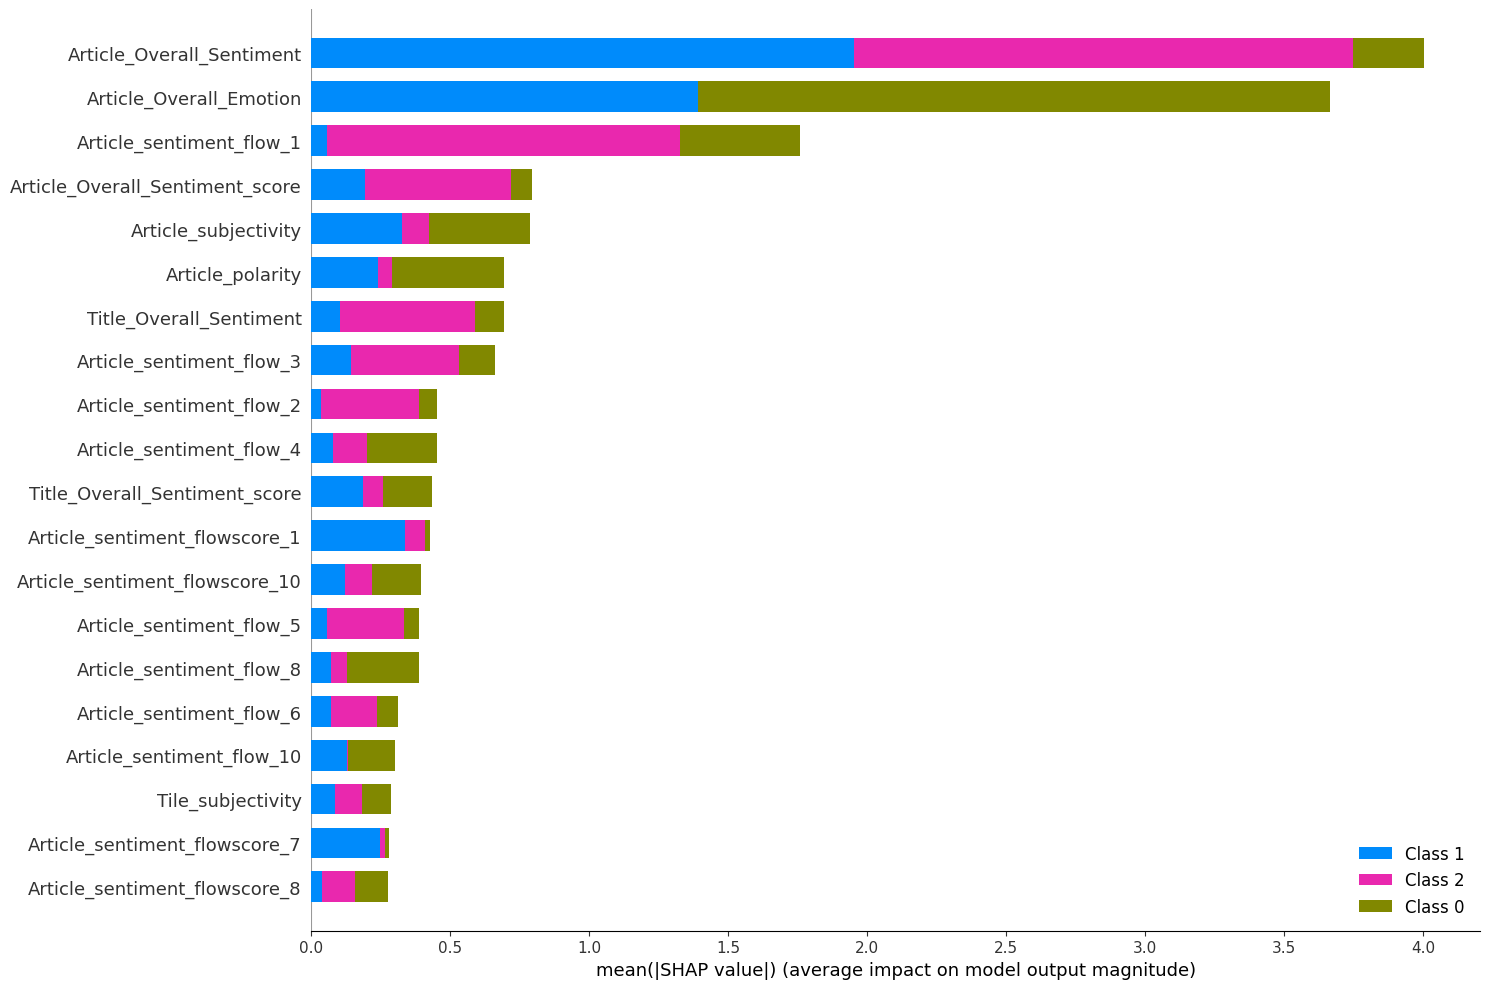

In [18]:
#Fit the model
clf_km.fit(lgbm_data, kmeans_labels)

#SHAP values
explainer_km = shap.TreeExplainer(clf_km)
shap_values_km = explainer_km.shap_values(lgbm_data)
shap.summary_plot(shap_values_km, lgbm_data, plot_type="bar", plot_size=(15, 10))

The Clusters are influenced by 
 - Over all sentiment of the Article (If an article's sentiment is very negative or positive or netural that affects the clusters which makes total sense)
 - Over all Emotion of the Article
 - What sentiment the article exibits when the article starts
 - How much personal opinions are shared in teh article
 - Polarity of teh article
 - What sentiment the Title represents

In [20]:
df_raw['Clusters'] =  kmeans_labels
df_temp = df_raw.groupby(['Clusters','Article_Overall_Sentiment', 'Article_Overall_Emotion']).agg({'Clusters':'count'})  \
                                                            .rename(columns={'Clusters':'Cluster_Count'}).reset_index()  \
                                                            .sort_values(by = ['Cluster_Count'],ascending=False).head(5) 

In [35]:
print('''The clusters are definbed by
      - 1 - Neutral anger
      - 0 - Neutral joy
      - 2 - Positive
      ''')
df_temp

In [43]:
df_temp = df_raw.groupby(['Meta_Publisher','Clusters']).agg({'Clusters':'count'}).rename(columns={'Clusters':'Cluster_Count'}).reset_index()
df_temp = df_temp.pivot_table(index='Meta_Publisher',columns='Clusters',values='Cluster_Count').fillna(0.0).reset_index()
df_temp['Dominant_Cluster'] = df_temp[[0,1,2]].idxmax(axis=1)

In [61]:
print('''We can bucket the Media Publishers into three buckets
      - Negative but neutrally negative
      - Negative with anger emotion
      - Postive with mild joy emotion

      - Negative but neutrally negative : Zee BusinessCNBCTV18.com,CNBCTV18.com,Times of India,Financial Times, Mint, The Hindu Business Line, Outlook india,
                                            The Economic Times
    
      - Negative with anger emotion : The Print, The Wire, The Hindu, Telegraph India, Business Today
      - Negative with mild joy and positive emotion : Swarajya, Tribune India, Republic,OpIndia, Onmanorama, India Today, Hindustan Times, Daily Pioneer  
      - Scroll is extremely Positive


      ''')
df_temp.sort_values('Dominant_Cluster')

We can bucket the Media Publishers into three buckets
      - Negative but neutrally negative
      - Negative with anger emotion
      - Postive with mild joy emotion

      - Negative but neutrally negative : Zee BusinessCNBCTV18.com,CNBCTV18.com,Times of India,Financial Times, Mint, The Hindu Business Line, Outlook india,
                                            The Economic Times
    
      - Negative with anger emotion : The Print, The Wire, The Hindu, Telegraph India, Business Today
      - Negative with mild joy and positive emotion : Swarajya, Tribune India, Republic,OpIndia, Onmanorama, India Today, Hindustan Times, Daily Pioneer  
      - Scroll is extremely Positive


      


Clusters,Meta_Publisher,0,1,2,Dominant_Cluster
23,Zee Business,2.0,0.0,0.0,0
1,CNBCTV18.com,3.0,2.0,0.0,0
21,Times of India,16.0,12.0,6.0,0
3,Financial Times,19.0,0.0,2.0,0
6,Mint,41.0,33.0,10.0,0
17,The Hindu Business Line,5.0,3.0,5.0,0
9,Outlook India,2.0,0.0,0.0,0
15,The Economic Times,38.0,26.0,14.0,0
20,Times Now,0.0,1.0,0.0,1
19,ThePrint,0.0,7.0,2.0,1


In [90]:
center_wing = df_raw[df_raw['Meta_Publisher'].isin(['Zee Business',
'CNBCTV18.com',
'Times of India',
'Financial Times',
'Mint',
'The Hindu Business Line',
'Outlook India',
'The Economic Times'
])]['Article'].str.cat(sep=' ').replace("Adani","").replace("Group","").replace("group","").replace("report","").replace("said","")

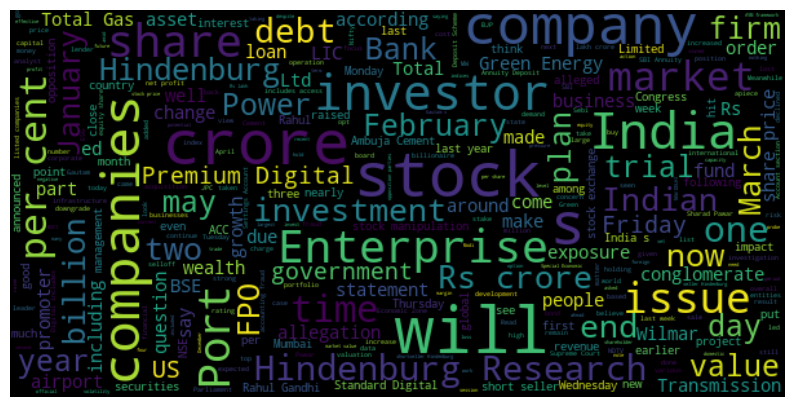

In [92]:
# Word Cloud
#txt = ' '.join(text for text in [(df_raw['Article'][0])])
plt.figure(figsize=(10,6))
wordcloud = WordCloud(
    background_color='black',
    max_font_size=50,
    max_words=300,
    height=300,
    width=600
).generate(center_wing)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [78]:
right_wing = df_raw[df_raw['Meta_Publisher'].isin(['SwarajyaMag',
'Tribune India',
'Republic',	
'OpIndia',	
'Onmanorama',
'India Today',
'Hindustan Times',
'Daily Pioneer',
'Telangana Today',
'Scroll'])]['Article'].str.cat(sep=' ').replace("Adani","").replace("Group","").replace("group","").replace("report","").replace("said","")

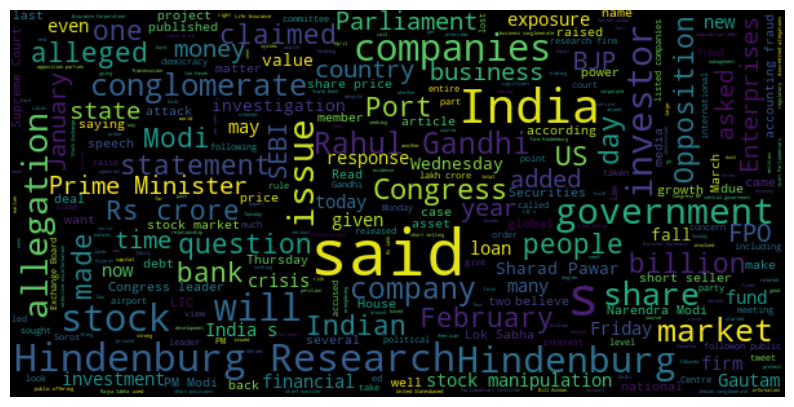

In [93]:
# Word Cloud
#txt = ' '.join(text for text in [(df_raw['Article'][0])])
plt.figure(figsize=(10,6))
wordcloud = WordCloud(
    background_color='black',
    max_font_size=50,
    max_words=300,
    height=300,
    width=600
).generate(right_wing)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [88]:
left_wing = df_raw[df_raw['Meta_Publisher'].isin(['Times Now',
'ThePrint',
'The Wire',
'The Hindu',
'Telegraph India'])]['Article'].str.cat(sep=' ').replace("Adani","").replace("Group","").replace("group","").replace("report","").replace("said","")

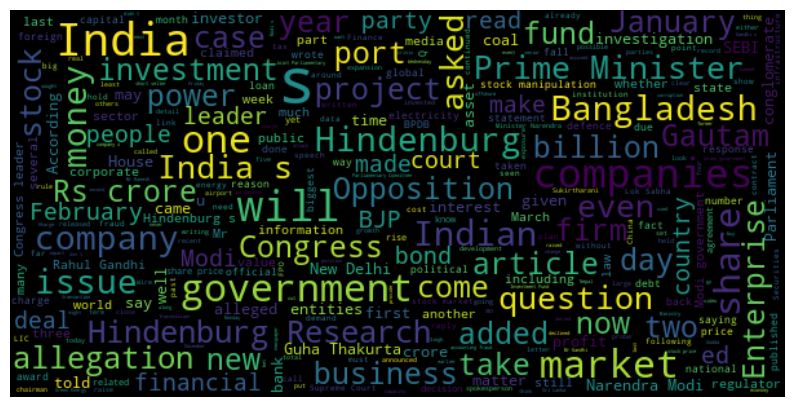

In [94]:
# Word Cloud
#txt = ' '.join(text for text in [(df_raw['Article'][0])])
plt.figure(figsize=(10,6))
wordcloud = WordCloud(
    background_color='black',
    max_font_size=50,
    max_words=300,
    height=300,
    width=600
).generate(left_wing)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

### Analysis & Insights Gathering

### Final Thoughts & Future Work